<a href="https://colab.research.google.com/github/EGR02/Goldman-Sachs-stock-prediction-seven-days-trend/blob/main/LSTM_7_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns

In [ ]:
GS = yf.download('GS', 
                      start='2000-01-01', 
                      end= datetime.now(), 
                      progress=False)

all_data = GS[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
#all_data.tail(5)
all_data.info()
print(all_data.tail)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5380 entries, 2000-01-03 to 2021-05-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5380 non-null   float64
 1   Open       5380 non-null   float64
 2   High       5380 non-null   float64
 3   Low        5380 non-null   float64
 4   Close      5380 non-null   float64
 5   Volume     5380 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 294.2 KB
<bound method NDFrame.tail of             Adj Close    Open    High     Low   Close   Volume
Date                                                          
2000-01-03      68.83   94.19   94.38   87.75   88.31  1822600
2000-01-04      64.49   87.00   87.50   82.25   82.75  1647700
2000-01-05      61.47   80.88   81.88   78.38   78.88  1516600
2000-01-06      64.10   78.62   84.50   78.62   82.25  1845100
2000-01-07      64.35   83.06   83.19   79.88   82.56  1127400
...               ...     ...    

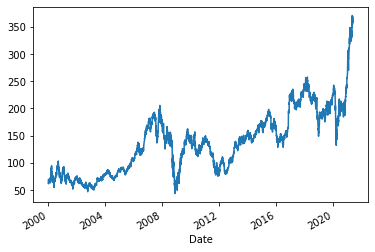

In [ ]:
plot1 = plt.figure(1)
all_data['Adj Close'].plot()
plt.show()

In [ ]:
#all_data = all_data[:].astype('float32')
all_data.dtypes
DataSet = all_data['Adj Close']

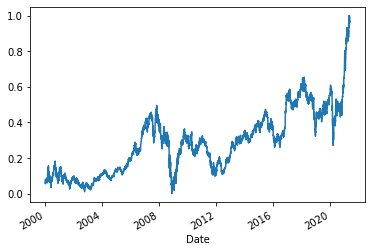

In [ ]:
plt.close()
DataSet = np.array(DataSet)
scaler = MinMaxScaler()
DataSet = DataSet.reshape(-1,1)
GS_scaled = pd.Series(scaler.fit_transform(DataSet).squeeze(), index = GS.index)
plot1 = plt.figure(1)
GS_scaled.plot()
plt.show()


In [ ]:
def univariate_data(data, window_size):
  y = data[window_size:]
  data = data.values.reshape(-1, 1)
  n = data.shape[0]
  x = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))

  return pd.DataFrame(x, index = y.index), y

In [ ]:
window_size = 63
x, y = create_univariate_rnn_data(GS_scaled, window_size)
#pd.Series(DataSet.squeeze() --> normal price
print(y)

Date
2000-04-03    0.118662
2000-04-04    0.101374
2000-04-05    0.099420
2000-04-06    0.119853
2000-04-07    0.111515
                ...   
2021-05-14    0.993525
2021-05-17    0.994991
2021-05-18    0.980666
2021-05-19    0.961790
2021-05-20    0.966066
Length: 5317, dtype: float64


In [ ]:
def targeting(data_y):
  y_ = []
  i = 0
  while i < len(data_y) - 7:
    y_.append([data_y[i:i+7]])
    i += 1
  y = np.array(y_)
  return y.reshape(-1,7,1), pd.DataFrame(data = y.reshape(-1,7), index = data_y.index[:(len(data_y)-7)])

y_array, y_serie = targeting(y)
print(y_array)

[[[0.11866219]
  [0.10137447]
  [0.09941967]
  ...
  [0.11151497]
  [0.12238852]
  [0.11701283]]

 [[0.10137447]
  [0.09941967]
  [0.11985339]
  ...
  [0.12238852]
  [0.11701283]
  [0.0973427 ]]

 [[0.09941967]
  [0.11985339]
  [0.11151497]
  ...
  [0.11701283]
  [0.0973427 ]
  [0.09422724]]

 ...

 [[1.        ]
  [0.99324985]
  [0.96649359]
  ...
  [0.96310324]
  [0.99352474]
  [0.99499084]]

 [[0.99324985]
  [0.96649359]
  [0.94963348]
  ...
  [0.99352474]
  [0.99499084]
  [0.98066585]]

 [[0.96649359]
  [0.94963348]
  [0.96310324]
  ...
  [0.99499084]
  [0.98066585]
  [0.96178986]]]


In [ ]:
x_train = x[:'2020-06-30'].values.reshape(-1, x.shape[1], 1)
x_valid = x['2020-07-01':'2021-03-31'].values.reshape(-1, x.shape[1],1)
x_test = x['2021-04-01':].values.reshape(-1, x.shape[1],1)
print(len(x_test))

# These represent the upper limit
L_Y_train = len(x) -len(x_valid) - len(x_test) 
L_Y_valid = len(x) - len(x_test) 



# Now, we create our target weeks
y_train = np.array(y_array[0:L_Y_train])
y_valid = np.array(y_array[L_Y_train:L_Y_valid])
y_test = np.array(y_array[L_Y_valid:])
#we won't have a y_test because we want to use x_test to make real predictions each time the model is run, 
#so we do not have to delay the data by the window size as we did for the other models.




print(x_valid.shape, y_valid.shape)
print(len(y_test))


35
(189, 63, 1) (189, 7, 1)
28


In [ ]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [ ]:
lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience= 70,
                              restore_best_weights=True)

In [ ]:

model = Sequential()
model.add(LSTM(units= 60, return_sequences = True, input_shape=(x_train.shape[1],1), activation='relu'))
model.add(LSTM(units= 60, activation='relu'))
model.add(Dense(units=7))

In [ ]:
# Compiling
model.compile(optimizer= 'adam',loss='mean_squared_error')

In [ ]:
# Fitting to the training set
history = model.fit(x_train,y_train,epochs = 1000,batch_size=140, verbose=0, validation_data=(x_valid,y_valid) ,callbacks= [early_stopping, checkpointer])



Epoch 00001: val_loss improved from inf to 0.01650, saving model to results/univariate_time_series/lstm.h5

Epoch 00002: val_loss improved from 0.01650 to 0.00736, saving model to results/univariate_time_series/lstm.h5

Epoch 00003: val_loss improved from 0.00736 to 0.00457, saving model to results/univariate_time_series/lstm.h5

Epoch 00004: val_loss improved from 0.00457 to 0.00383, saving model to results/univariate_time_series/lstm.h5

Epoch 00005: val_loss improved from 0.00383 to 0.00325, saving model to results/univariate_time_series/lstm.h5

Epoch 00006: val_loss did not improve from 0.00325

Epoch 00007: val_loss improved from 0.00325 to 0.00278, saving model to results/univariate_time_series/lstm.h5

Epoch 00008: val_loss did not improve from 0.00278

Epoch 00009: val_loss improved from 0.00278 to 0.00266, saving model to results/univariate_time_series/lstm.h5

Epoch 00010: val_loss improved from 0.00266 to 0.00244, saving model to results/univariate_time_series/lstm.h5

Epo

In [ ]:
#prediction = model.predict(x_test[-1].reshape(1,63,1))
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)
#print(x_test[-1].reshape(1,63,1))
#print(prediction)

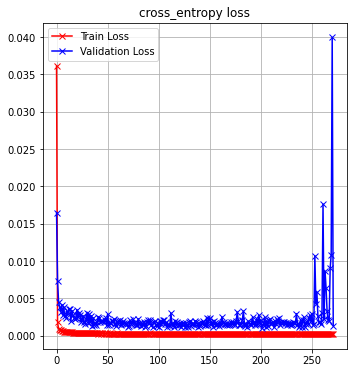

In [ ]:
#print(history.history.keys())
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)
    

plot_loss_accuracy(history)
#print(history.history.keys())


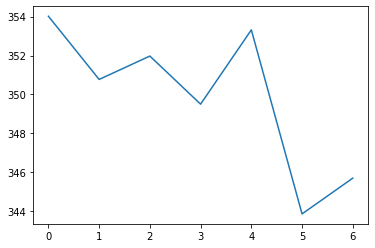

In [ ]:
plt.plot(prediction[-1])
plt.show()

In [ ]:
dates = []
i = 0
while i <7:
  dates.append((datetime.now() + timedelta(days=i))) #.strftime('%Y-%m-%d')
  i += 1



In [ ]:
preds = np.array(prediction).reshape(-1,7)
preds = pd.DataFrame(data = preds[-1], index = dates)
gs_adj = pd.DataFrame(data = GS["Adj Close"]['2021-04-01':], index = GS.index[-len(x_test):])



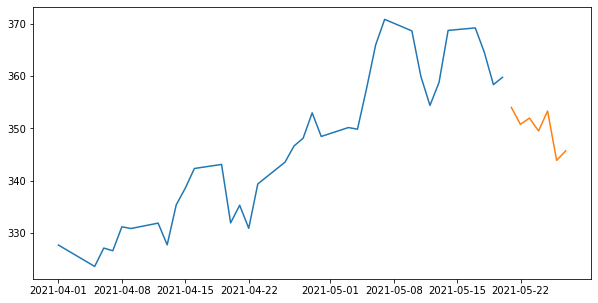

In [ ]:
merge=pd.concat([gs_adj , preds], axis = 1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(merge["Adj Close"], label = "Adj Close")
ax.plot(merge[0], label = "Future Trend")
plt.show()

In [ ]:
train_predict = model.predict(x_train)
valid_predict = model.predict(x_valid)
test_predict = model.predict(x_test)

In [ ]:
train_predict1 = pd.DataFrame(scaler.inverse_transform(train_predict).squeeze(), index = y_serie[:'2020-06-30'].index)
valid_predict1 = pd.DataFrame(scaler.inverse_transform(valid_predict).squeeze(), index = y_serie['2020-07-01':'2021-03-31'].index)
test_predict1 = pd.DataFrame(scaler.inverse_transform(test_predict).squeeze(), index = GS_scaled['2021-04-01':].index)

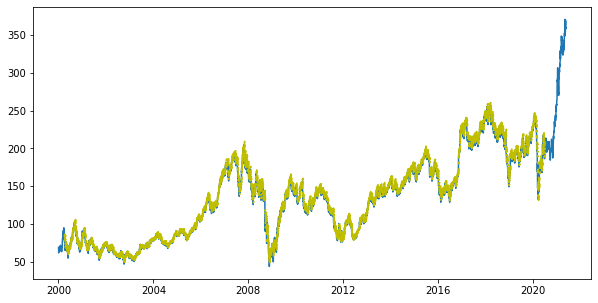

In [ ]:
plt.close()
#Plotting the training prediction results

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
index1 = all_data.index[window_size:]
plt.plot(all_data['Adj Close'])
i = 0
for date in train_predict1.index:
  t = train_predict1[date:date].T
  ax.plot(pd.DataFrame( data = t[date].values, index = index1[i: i + 7]), 'y')
  i += 1

plt.show()


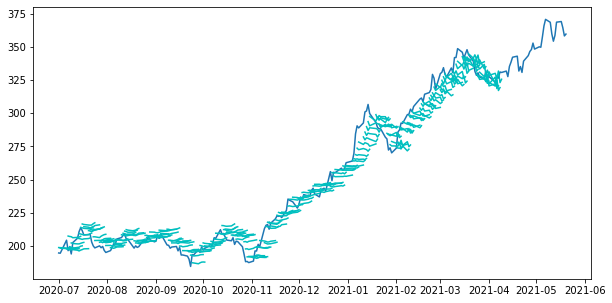

In [ ]:
plt.close()
#Plotting the validation prediction results

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.plot(all_data['Adj Close']['2020-07-01':])
for date in valid_predict1.index:
  t = valid_predict1[date:date].T
  ax.plot(pd.DataFrame( data = t[date].values, index = index1[i: i + 7]), 'c')
  i += 1

plt.show()

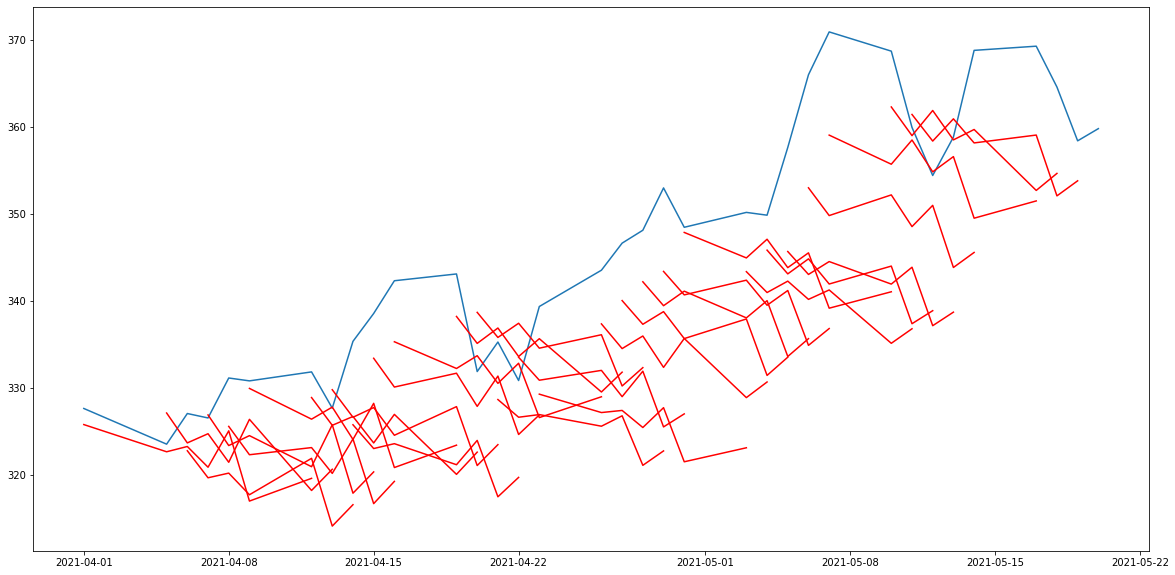

In [ ]:
plt.close()
#Plotting the validation prediction results without the last seven predictions

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.plot(all_data['Adj Close']['2021-04-01':])
for date in test_predict1.index[:-7]:
  t = test_predict1[date:date].T
  ax.plot(pd.DataFrame( data = t[date].values, index = index1[i: i + 7]), 'r')
  i += 1

plt.show()

In [ ]:
y_train_rescaled = scaler.inverse_transform(y_train.squeeze())

train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, train_predict1))# Train Standard Deviation

y_valid_rescaled = scaler.inverse_transform(y_valid.squeeze())
valid_rmse = np.sqrt(mean_squared_error(y_valid_rescaled,valid_predict1))# Valid Standard Deviation

y_test_rescaled = scaler.inverse_transform(y_test.squeeze())
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_predict1[:-7]))# Test Standard Deviation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

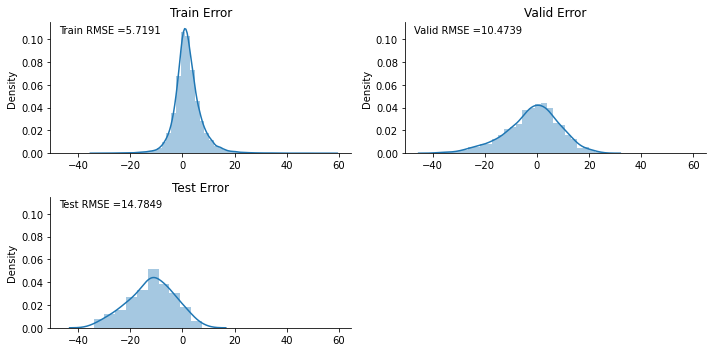

In [ ]:
fig=plt.figure(figsize=(10,5))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222, sharex = ax1, sharey = ax1)
ax3 = plt.subplot(223, sharex= ax2, sharey= ax2)
sns.distplot(train_predict1 - y_train_rescaled, ax=ax1)
ax1.set_title('Train Error')
ax1.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax1.transAxes)
sns.distplot(valid_predict1 - y_valid_rescaled, ax=ax2)
ax2.set_title('Valid Error')
ax2.text(x=.03, y=.92, s=f'Valid RMSE ={valid_rmse:.4f}', transform=ax2.transAxes)
sns.distplot(test_predict1[:-7] - y_test_rescaled, ax=ax3)
ax3.set_title('Test Error')
ax3.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax3.transAxes)

sns.despine()
fig.tight_layout()